# Assignment 3

## Generate Dataset

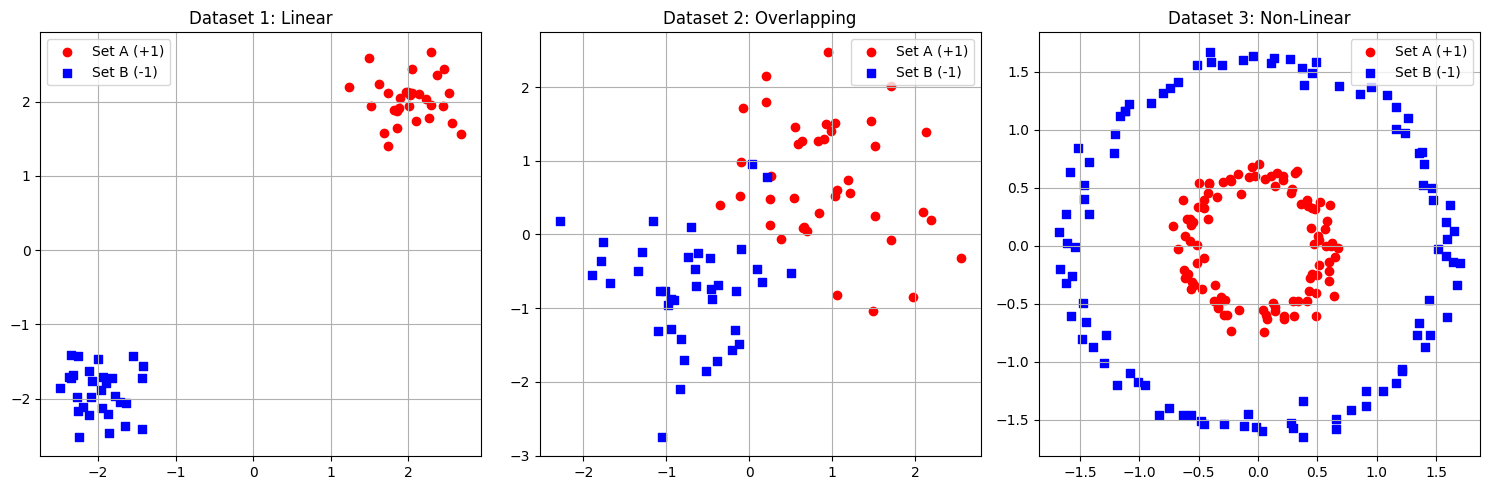

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_svm_datasets():
    np.random.seed(0)
    A1 = np.random.randn(30, 2) * 0.3 + np.array([2, 2])
    B1 = np.random.randn(30, 2) * 0.3 + np.array([-2, -2])
    # Labels: A1 -> +1, B1 -> -1
   
    np.random.seed(1)
    A2 = np.random.randn(40, 2) * 0.8 + np.array([0.8, 0.8])
    B2 = np.random.randn(40, 2) * 0.8 + np.array([-0.8, -0.8])
   
    np.random.seed(2)
    n_points = 100
    theta = np.linspace(0, 2*np.pi, n_points)
   
    r_inner = 0.6
    A3 = np.c_[r_inner * np.cos(theta), r_inner * np.sin(theta)]
    A3 += np.random.randn(n_points, 2) * 0.07
   
    r_outer = 1.6
    B3 = np.c_[r_outer * np.cos(theta), r_outer * np.sin(theta)]
    B3 += np.random.randn(n_points, 2) * 0.07
   
    return (A1, B1), (A2, B2), (A3, B3)

(setA1, setB1), (setA2, setB2), (setA3, setB3) = generate_svm_datasets()

plt.figure(figsize=(15, 5))
datasets = [(setA1, setB1, "Dataset 1: Linear"),
            (setA2, setB2, "Dataset 2: Overlapping"),
            (setA3, setB3, "Dataset 3: Non-Linear")]

for i, (A, B, title) in enumerate(datasets):
    plt.subplot(1, 3, i+1)
    plt.scatter(A[:, 0], A[:, 1], c='red', marker='o', label='Set A (+1)')
    plt.scatter(B[:, 0], B[:, 1], c='blue', marker='s', label='Set B (-1)')
    plt.title(title)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig("fig1.png", bbox_inches='tight')
plt.show()

## Check for existance of linear classifier

In [5]:
import cvxpy as cp

def solve_linear_svm(setA, setB):
    # Prepare data: A is +1, B is -1
    X = np.vstack([setA, setB])
    y = np.hstack([np.ones(len(setA)), -np.ones(len(setB))])

    N, D = X.shape
    
    w = cp.Variable(D)
    b = cp.Variable()

    # Constraints: y_i * (w^T * x_i + b) >= 1
    constraints = [cp.multiply(y, X @ w + b) >= 1]
    
    # Objective: Minimize 0.5 * ||w||^2
    prob = cp.Problem(cp.Minimize(0.5 * cp.sum_squares(w)), constraints)
    
    try:
        prob.solve()
        if prob.status == cp.OPTIMAL:
            return w.value, b.value
        else:
            return None, None
    except:
        return None, None

# Test the datasets
datasets = [ (setA1, setB1, "Dataset 1"), (setA2, setB2, "Dataset 2"), (setA3, setB3, "Dataset 3") ]

for A, B, name in datasets:
    w, b = solve_linear_svm(A, B)
    if w is not None:
        print(f"{name}: Linearly Separable!")
        print(f"   Hyperplane: {w[0]:.2f}x + {w[1]:.2f}y + {b:.2f} = 0")
    else:
        print(f"{name}: Not Linearly Separable.")

Dataset 1: Linearly Separable!
   Hyperplane: 0.34x + 0.32y + -0.03 = 0
Dataset 2: Not Linearly Separable.
Dataset 3: Not Linearly Separable.


## Solution for Primal and Dual problem and Verification of KKT condition

In [6]:
# 1. Prepare Data (Dataset 1)
X = np.vstack([setA1, setB1])
y = np.hstack([np.ones(len(setA1)), -np.ones(len(setB1))])
N, d = X.shape

# --- 2. PRIMAL PROBLEM ---
w_p = cp.Variable(d)
b_p = cp.Variable()
# Objective: 1/2 * ||w||^2
primal_obj = cp.Minimize(0.5 * cp.sum_squares(w_p))
# Constraints: y_i(w.T @ x_i + b) >= 1
primal_con = [cp.multiply(y, X @ w_p + b_p) >= 1]
prob_p = cp.Problem(primal_obj, primal_con)
prob_p.solve()

# --- 3. DUAL PROBLEM ---
alpha = cp.Variable(N)
# Gram Matrix P_ij = y_i * y_j * (x_i . x_j)
P = np.outer(y, y) * (X @ X.T)
# Use psd_wrap to ensure CVXPY recognizes the matrix as PSD
dual_obj = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(alpha, cp.psd_wrap(P)))
dual_con = [alpha >= 0, cp.sum(cp.multiply(alpha, y)) == 0]
prob_d = cp.Problem(dual_obj, dual_con)
prob_d.solve()

# --- 4. PARAMETER RECOVERY ---
# w from dual: w = sum(alpha_i * y_i * x_i)
w_from_dual = np.sum((alpha.value[:, None] * y[:, None] * X), axis=0)

# b from dual: Find a support vector (alpha > 0)
# b = y_k - w.T @ x_k
sv_indices = np.where(alpha.value > 1e-5)[0]
b_from_dual = y[sv_indices[0]] - w_from_dual @ X[sv_indices[0]]

# --- 5. PRINT RESULTS & KKT VERIFICATION ---
print("-" * 30)
print("SVM SOLVER RESULTS (Dataset 1)")
print("-" * 30)
print(f"Primal weights (w): {w_p.value}")
print(f"Dual weights (w):   {w_from_dual}")
print(f"Primal bias (b):    {b_p.value:.4f}")
print(f"Dual bias (b):      {b_from_dual:.4f}")
print("\n" + "-" * 30)
print("KKT CONDITION VERIFICATION")
print("-" * 30)

# 1. Stationarity
stationarity_err = np.linalg.norm(w_p.value - w_from_dual)
print(f"1. Stationarity (||w_p - w_d||): {stationarity_err:.2e}")

# 2. Primal Feasibility
min_margin = np.min(y * (X @ w_p.value + b_p.value))
print(f"2. Primal Feasibility (Min Margin >= 1): {min_margin:.4f}")

# 3. Dual Feasibility
min_alpha = np.min(alpha.value)
print(f"3. Dual Feasibility (Min alpha >= 0): {min_alpha:.2e}")

# 4. Complementary Slackness
# alpha_i * (y_i(w.T x_i + b) - 1) should be 0
margin_gap = y * (X @ w_p.value + b_p.value) - 1
slackness = np.abs(alpha.value * margin_gap)
print(f"4. Max Complementary Slackness: {np.max(slackness):.2e}")
print(f"   Number of Support Vectors: {len(sv_indices)}")
print("-" * 30)

------------------------------
SVM SOLVER RESULTS (Dataset 1)
------------------------------
Primal weights (w): [0.33696807 0.31613427]
Dual weights (w):   [0.33696807 0.31613427]
Primal bias (b):    -0.0286
Dual bias (b):      -0.0286

------------------------------
KKT CONDITION VERIFICATION
------------------------------
1. Stationarity (||w_p - w_d||): 7.85e-17
2. Primal Feasibility (Min Margin >= 1): 1.0000
3. Dual Feasibility (Min alpha >= 0): -9.29e-23
4. Max Complementary Slackness: 2.37e-17
   Number of Support Vectors: 2
------------------------------


## Plotting Solution of Dataset 1

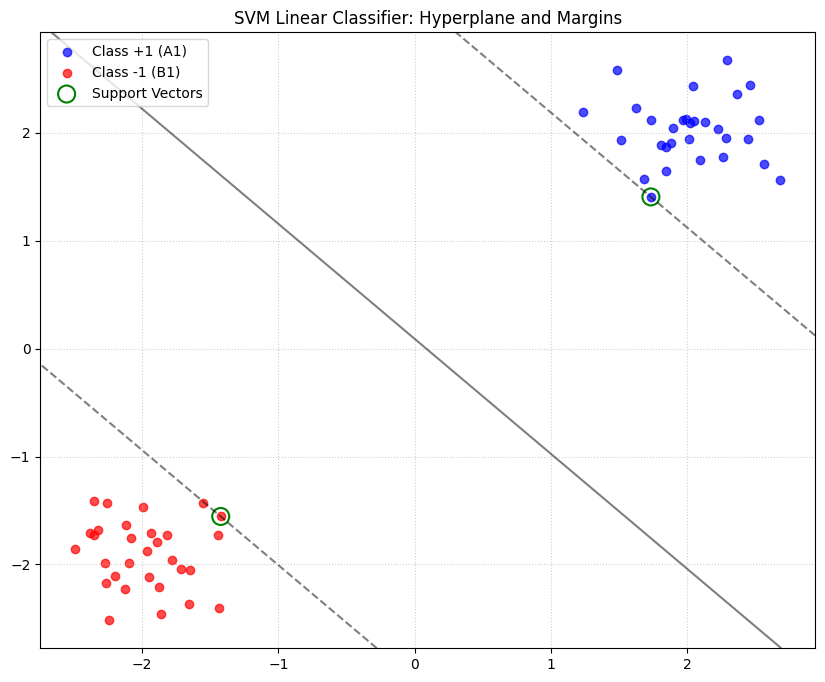

In [7]:
def plot_svm_results(setA, setB, w, b, alpha):
    plt.figure(figsize=(10, 8))
    
    # Plot the data points
    plt.scatter(setA[:, 0], setA[:, 1], c='blue', label='Class +1 (A1)', alpha=0.7)
    plt.scatter(setB[:, 0], setB[:, 1], c='red', label='Class -1 (B1)', alpha=0.7)
    
    # Define plot limits
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    # Calculate decision boundary and margins: Z = w[0]*x + w[1]*y + b
    Z = (xy @ w + b).reshape(XX.shape)
    
    # Plot decision boundary and margins
    # level 0 is the hyperplane, levels -1 and 1 are the margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # Highlight Support Vectors (where alpha > 1e-5)
    X_all = np.vstack([setA, setB])
    sv_idx = np.where(alpha > 1e-5)[0]
    plt.scatter(X_all[sv_idx, 0], X_all[sv_idx, 1], s=150,
                linewidth=1.5, facecolors='none', edgecolors='green', 
                label='Support Vectors')

    plt.title("SVM Linear Classifier: Hyperplane and Margins")
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.savefig("fig2.png", bbox_inches='tight')
    plt.show()

# Run the plotting function using values from the previous code block
plot_svm_results(setA1, setB1, w_p.value, b_p.value, alpha.value)

## Classifying Dataset with Relaxed SVM Conditions

Dataset 2 (Overlapping Clusters):
Hyperplane: 1.5280x + 1.1947y + -0.0364 = 0
Number of outliers (points violating the margin): 13


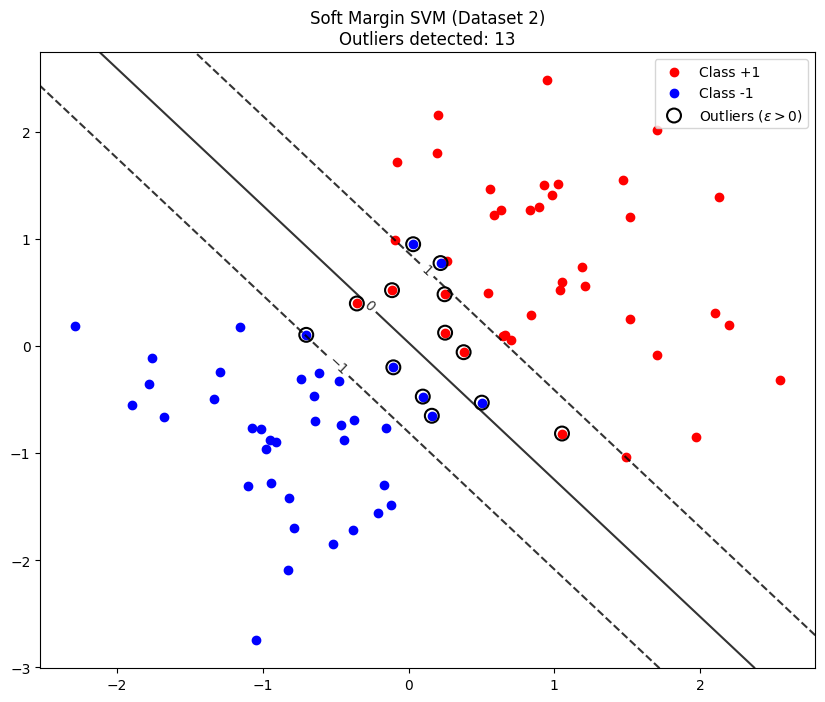

In [11]:
def solve_soft_margin_svm(setA, setB, C=1.0):
    X = np.vstack([setA, setB])
    y = np.hstack([np.ones(len(setA)), -np.ones(len(setB))])
    N, d = X.shape

    w = cp.Variable(d)
    b = cp.Variable()
    xi = cp.Variable(N)  # Slack variables

    # Objective: 0.5*||w||^2 + C * sum(xi)
    obj = cp.Minimize(0.5 * cp.sum_squares(w) + C * cp.sum(xi))
    
    # Constraints
    constraints = [
        cp.multiply(y, X @ w + b) >= 1 - xi,
        xi >= 0
    ]
    
    prob = cp.Problem(obj, constraints)
    prob.solve()
    
    # Identify outliers: points where xi > 0 (using a small threshold for noise)
    outliers_idx = np.where(xi.value > 1e-5)[0]
    
    return w.value, b.value, xi.value, outliers_idx

def plot_soft_margin_results(setA, setB, w, b, xi):
    plt.figure(figsize=(10, 8))
    
    # Plot the data points
    plt.scatter(setA[:, 0], setA[:, 1], c='red', label='Class +1')
    plt.scatter(setB[:, 0], setB[:, 1], c='blue', label='Class -1')
    
    # Define plot limits
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 100)
    yy = np.linspace(ylim[0], ylim[1], 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    # Calculate decision boundary Z = w.T @ x + b
    Z = (xy @ w + b).reshape(XX.shape)
    
    # Plot decision boundary (0) and margins (-1, 1)
    cont = ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.8,
               linestyles=['--', '-', '--'])
    plt.clabel(cont, inline=True, fontsize=10)
    
    # Highlight Outliers (xi > 1e-5)
    X_all = np.vstack([setA, setB])
    outlier_idx = np.where(xi > 1e-5)[0]
    plt.scatter(X_all[outlier_idx, 0], X_all[outlier_idx, 1], s=100,
                linewidth=1.5, facecolors='none', edgecolors='black', 
                label=r'Outliers ($\epsilon > 0$)')

    plt.title(f"Soft Margin SVM (Dataset 2)\nOutliers detected: {len(outlier_idx)}")
    plt.legend()
    plt.show()

# Solve for Dataset 2
w2, b2, xi2, outliers2 = solve_soft_margin_svm(setA2, setB2, C=1.0)

print(f"Dataset 2 (Overlapping Clusters):")
print(f"Hyperplane: {w2[0]:.4f}x + {w2[1]:.4f}y + {b2:.4f} = 0")
print(f"Number of outliers (points violating the margin): {len(outliers2)}")

plot_soft_margin_results(setA2, setB2, w2, b2, xi2)

## Solving Dataset With a Non-Linear Classifier

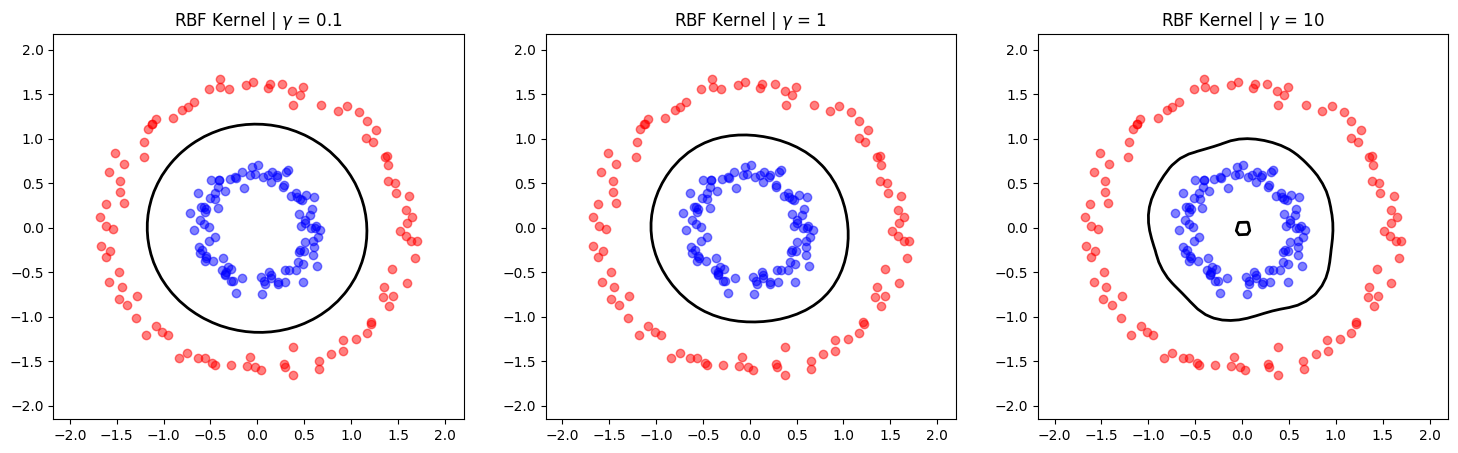

In [13]:
def rbf_kernel(X, Y, gamma):
    # Efficiently compute ||x-y||^2 using expansion: x^2 - 2xy + y^2
    X_sq = np.sum(X**2, axis=1).reshape(-1, 1)
    Y_sq = np.sum(Y**2, axis=1).reshape(1, -1)
    sq_dists = X_sq + Y_sq - 2 * (X @ Y.T)
    return np.exp(-gamma * sq_dists)

def solve_kernel_svm(X, y, gamma, C=1.0):
    N = X.shape[0]
    K = rbf_kernel(X, X, gamma)
    # P matrix for CVXPY: P_ij = y_i * y_j * K(x_i, x_j)
    P = np.outer(y, y) * K
    
    alpha = cp.Variable(N)
    obj = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(alpha, cp.psd_wrap(P)))
    constraints = [alpha >= 0, alpha <= C, cp.sum(cp.multiply(alpha, y)) == 0]
    
    prob = cp.Problem(obj, constraints)
    prob.solve()
    
    # Calculate bias b using support vectors (where 0 < alpha < C)
    # Average over support vectors for stability
    sv_idx = np.where((alpha.value > 1e-4) & (alpha.value < C - 1e-4))[0]
    if len(sv_idx) == 0: # Fallback to all support vectors if none are strictly inside
        sv_idx = np.where(alpha.value > 1e-4)[0]
    
    # Decision function: f(x) = sum(alpha_i * y_i * K(x_i, x)) + b
    # We find b such that f(x_sv) = y_sv
    k_sv = K[:, sv_idx]
    b = np.mean(y[sv_idx] - np.sum((alpha.value * y)[:, None] * k_sv, axis=0))
    
    return alpha.value, b

# Dataset 3 (Circular) is the best candidate for this
X3 = np.vstack([setA3, setB3])
y3 = np.hstack([np.ones(len(setA3)), -np.ones(len(setB3))])

gammas = [0.1, 1, 10]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, g in enumerate(gammas):
    alphas, b = solve_kernel_svm(X3, y3, gamma=g, C=1.0)
    
    # Plotting logic
    ax = axes[i]
    ax.scatter(setA3[:, 0], setA3[:, 1], c='blue', alpha=0.5)
    ax.scatter(setB3[:, 0], setB3[:, 1], c='red', alpha=0.5)
    
    # Create grid for decision boundary
    x_min, x_max = X3[:, 0].min() - 0.5, X3[:, 0].max() + 0.5
    y_min, y_max = X3[:, 1].min() - 0.5, X3[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Evaluate decision function on grid
    K_grid = rbf_kernel(X3, grid_points, gamma=g)
    Z = (np.sum((alphas * y3)[:, None] * K_grid, axis=0) + b).reshape(xx.shape)
    
    ax.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)
    ax.set_title(fr"RBF Kernel | $\gamma$ = {g}")

plt.show()

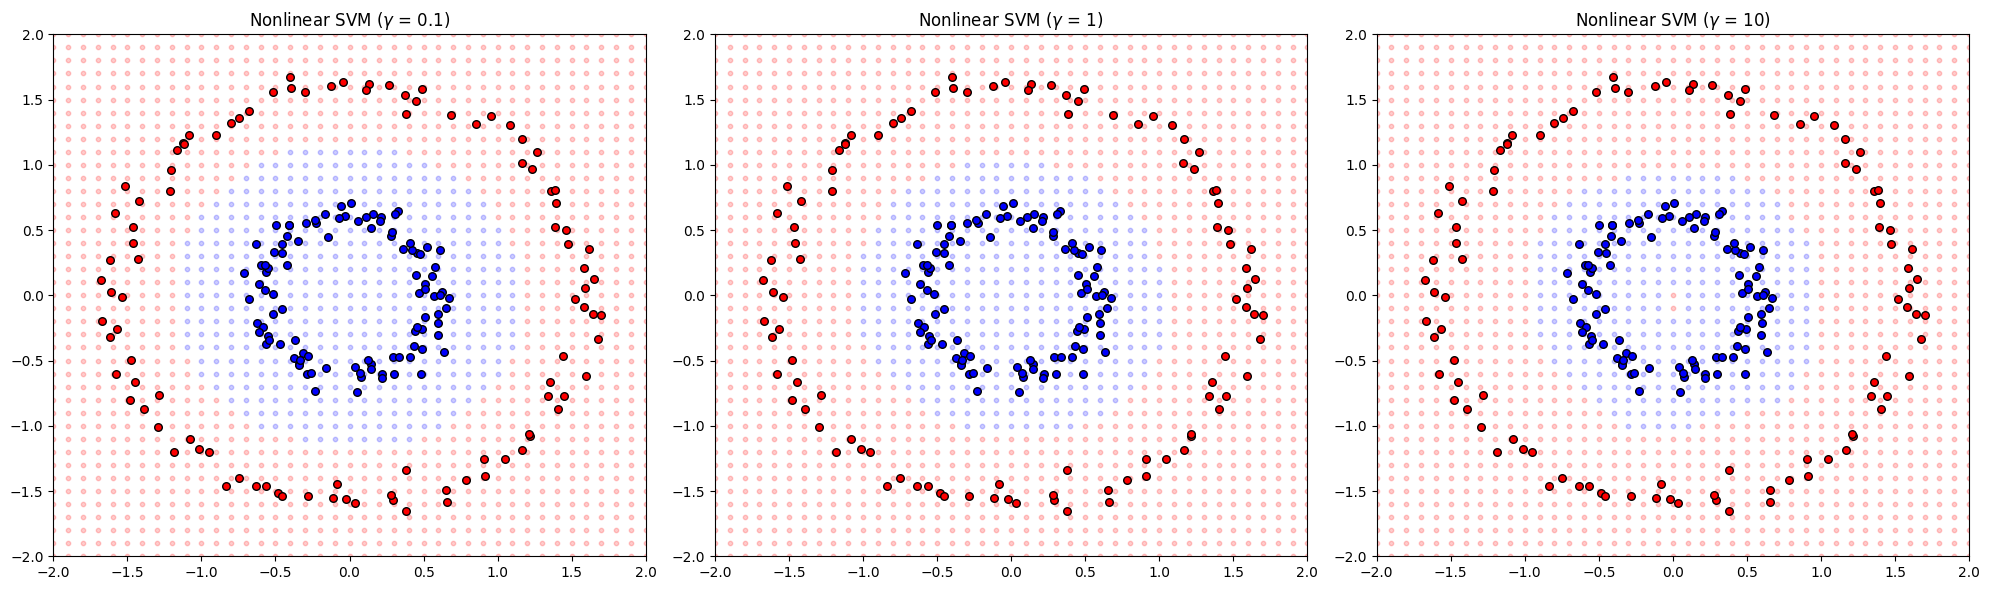

In [15]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

def rbf_kernel(X1, X2, gamma):
    # Compute the Gaussian Kernel Matrix
    sq_norm1 = np.sum(X1**2, axis=1).reshape(-1, 1)
    sq_norm2 = np.sum(X2**2, axis=1).reshape(1, -1)
    dists = sq_norm1 + sq_norm2 - 2 * np.dot(X1, X2.T)
    return np.exp(-gamma * dists)

def solve_nonlinear_svm(X, y, gamma, C=1.0):
    n = X.shape[0]
    K = rbf_kernel(X, X, gamma)
    P = cp.psd_wrap(np.outer(y, y) * K)
    
    alpha = cp.Variable(n)
    prob = cp.Problem(cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(alpha, P)),
                      [alpha >= 0, alpha <= C, cp.sum(cp.multiply(alpha, y)) == 0])
    prob.solve()
    
    # Calculate bias b using points on the margin (0 < alpha < C)
    idx = np.where((alpha.value > 1e-4) & (alpha.value < C - 1e-4))[0]
    if len(idx) == 0: idx = np.where(alpha.value > 1e-4)[0]
    
    # b = y_k - sum(alpha_i * y_i * K(x_i, x_k))
    b = np.mean(y[idx] - np.sum((alpha.value * y)[:, None] * K[:, idx], axis=0))
    return alpha.value, b

# Grid setup
resolution = 0.1
grid_range = np.arange(-2, 2 + resolution, resolution)
xx, yy = np.meshgrid(grid_range, grid_range)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Prepare Dataset 3
X3 = np.vstack([setA3, setB3])
y3 = np.hstack([np.ones(len(setA3)), -np.ones(len(setB3))])

gammas = [0.1, 1, 10]
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, gamma in enumerate(gammas):
    alpha_vals, b_val = solve_nonlinear_svm(X3, y3, gamma)
    
    # Predict on grid: f(x) = sign(sum(alpha_i * y_i * K(x_i, x_grid)) + b)
    K_grid = rbf_kernel(X3, grid_points, gamma)
    decision_values = np.sum((alpha_vals * y3)[:, None] * K_grid, axis=0) + b_val
    grid_labels = np.sign(decision_values)
    
    # Plot grid
    axes[i].scatter(grid_points[grid_labels == 1, 0], grid_points[grid_labels == 1, 1], 
                    color='blue', s=10, alpha=0.2, label='Grid +1')
    axes[i].scatter(grid_points[grid_labels == -1, 0], grid_points[grid_labels == -1, 1], 
                    color='red', s=10, alpha=0.2, label='Grid -1')
    
    # Overlay original points
    axes[i].scatter(setA3[:, 0], setA3[:, 1], c='blue', edgecolors='k', s=30, label='Data +1')
    axes[i].scatter(setB3[:, 0], setB3[:, 1], c='red', edgecolors='k', s=30, label='Data -1')
    
    axes[i].set_title(rf"Nonlinear SVM ($\gamma$ = {gamma})")
    axes[i].set_xlim([-2, 2])
    axes[i].set_ylim([-2, 2])

plt.tight_layout()
plt.show()